In [4]:
#Import necessary libraries for data
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import joblib
from zlib import crc32
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy import stats
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



In [5]:
#Data link
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/data/data.tgz"

## Data Related Functions

In [9]:
def fetch_data_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

def clean_housing_data(data):
    data=load_housing_data()
    

## Data Loading

In [11]:
##create data folder
#fetch_data_data() 404 http error coming
data=load_housing_data()
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Basic Details of Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
data.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# EDA

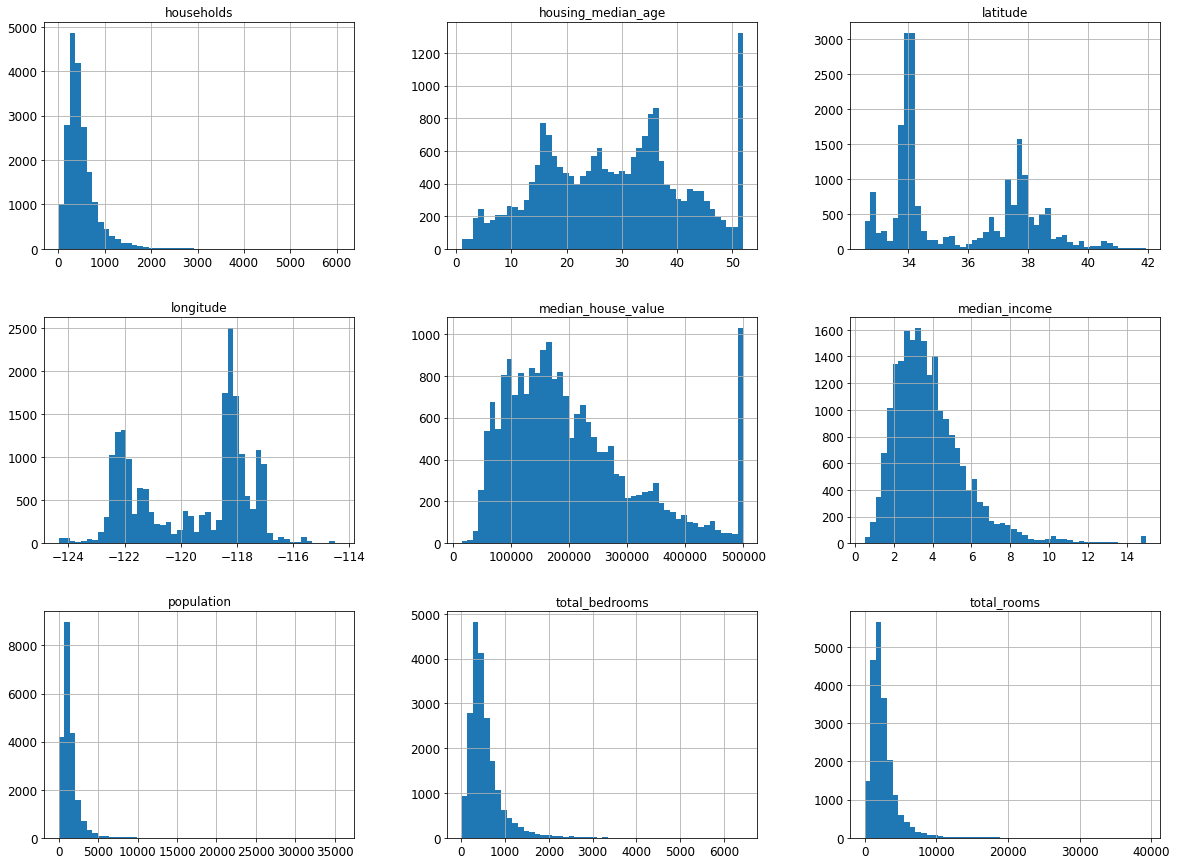

In [9]:

%matplotlib inline  
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

### Train Test Split

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(data, 0.2)
print("Train & Test Set Length: ",str(len(train_set)),str(len(test_set)))

Train & Test Set Length:  16512 4128


### Stable Train Test Split
Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., with np.random.seed(42))14 before calling np.random.permutation() so that it always generates the same shuffled indices.

But both these solutions will break the next time you fetch an updated dataset. To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

Here is a possible implementation:

In [12]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
data_with_id = data.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(data_with_id, 0.2, "index")

In [14]:
#id_column creation
data_with_id["id"] = data["longitude"] * 1000 + data["latitude"]
train_set, test_set = split_train_test_by_id(data_with_id, 0.2, "id")

In [15]:
#another (Most Famous) Random Sampling technique
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


<AxesSubplot:>

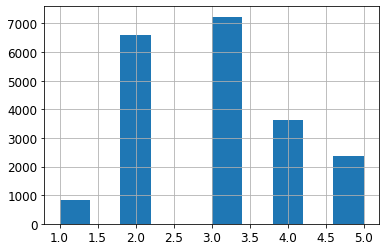

In [16]:
## Income Category Analysis
data["income_cat"] = pd.cut(data["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

data["income_cat"].hist()

### Stratified Sampling Technique
So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a 12% chance of sampling a skewed test set that was either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely (back in Figure 2-8): most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Visualise the Location Data

In [20]:
train_data_copy = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

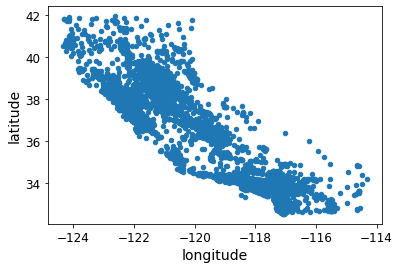

In [21]:
train_data_copy.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

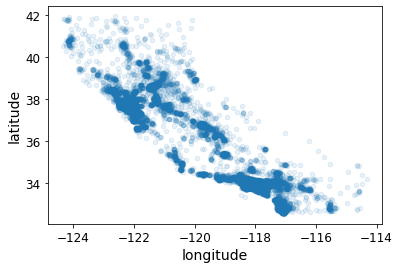

In [22]:
train_data_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
# This looks like California all right, but other than that it is hard to see any particular pattern. 
# #Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points

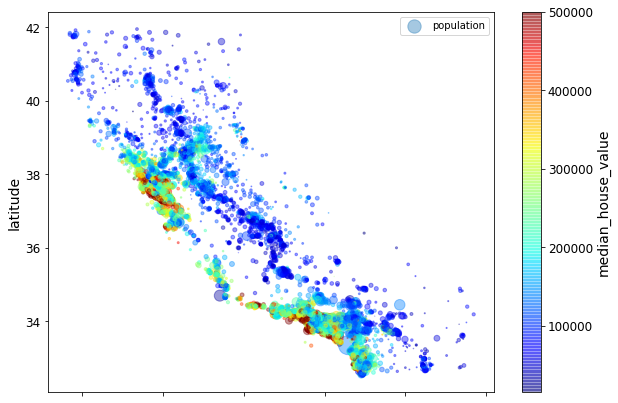

In [23]:
train_data_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=train_data_copy["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [24]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x1cfa2658b80>)

Saving figure california_housing_prices_plot


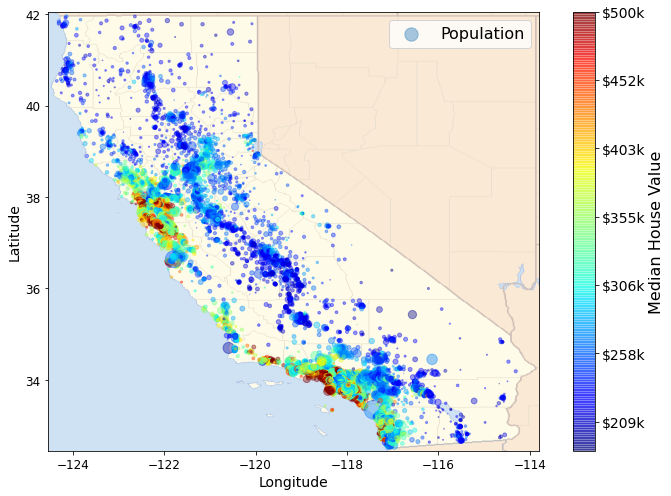

In [26]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = data.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=data['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Correlation Matrix

In [27]:
corr_matrix = train_data_copy.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

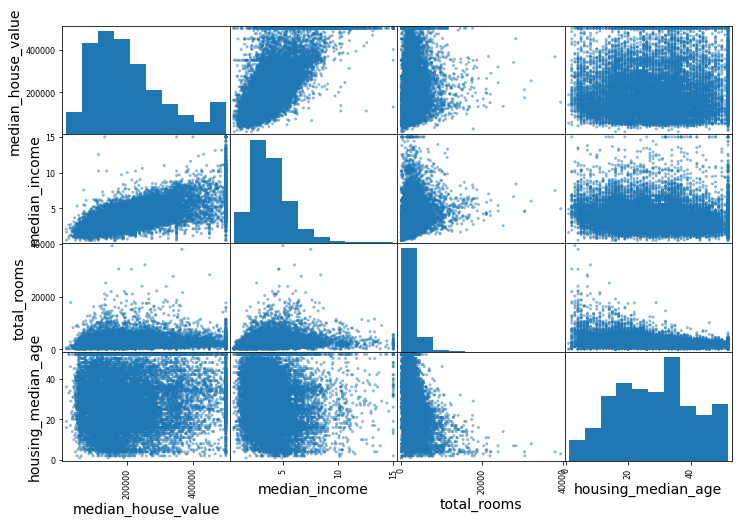

In [28]:


attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(train_data_copy[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

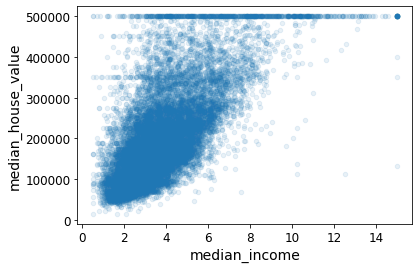

In [29]:
train_data_copy.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

### Experimenting with Attribute Combinations

In [30]:
train_data_copy["rooms_per_household"] = train_data_copy["total_rooms"]/train_data_copy["households"]
train_data_copy["bedrooms_per_room"] = train_data_copy["total_bedrooms"]/train_data_copy["total_rooms"]
train_data_copy["population_per_household"]=train_data_copy["population"]/train_data_copy["households"]

In [31]:
corr_matrix = train_data_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Data Cleaning

In [81]:
x_features = strat_train_set.drop("median_house_value", axis=1)
y_feature = strat_train_set["median_house_value"].copy()

In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

x_features_num = x_features.drop("ocean_proximity", axis=1)

imputer.fit(x_features_num)

print(imputer.statistics_)

print(x_features_num.median().values)

X = imputer.transform(x_features_num)

housing_tr = pd.DataFrame(X, columns=x_features_num.columns,
                          index=x_features_num.index)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


### Handling Text and Categorical Attributes

In [82]:
x_features_cat = x_features[["ocean_proximity"]]
x_features_cat.head()


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


### Custom Transformers

In [83]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    strat_train_set.columns.get_loc(c) for c in col_names] # get the column indices
print(rooms_ix, bedrooms_ix, population_ix, households_ix)

3 4 5 6


In [84]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
data_extra_attribs = attr_adder.transform(x_features.values)

In [85]:
data_extra_attribs = pd.DataFrame(
    data_extra_attribs,
    columns=list(x_features.columns)+["rooms_per_household", "population_per_household","bedrooms_per_room"],
    index=x_features.index)
data_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944,0.223852
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796,0.159057
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597,0.241291
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598,0.200866
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785,0.231341


In [86]:
#Preprocessing Pipeline with numerical columns
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

#x_features_num_tr = num_pipeline.fit_transform(x_features_num)

In [87]:
'''for i in x_features.columns:
    if(i!='ocean_proximity'):
        #data_extra_attribs[i]=data_extra_attribs[i].astype(float)
        print(i,x_features[i].dtype)'''

"for i in x_features.columns:\n    if(i!='ocean_proximity'):\n        #data_extra_attribs[i]=data_extra_attribs[i].astype(float)\n        print(i,x_features[i].dtype)"

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(x_features.select_dtypes(include=['float64']).columns)
cat_attribs = list(x_features.select_dtypes(include=['object']).columns)

#full pipeline to Preprocess the data
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

x_added_features_prepared = full_pipeline.fit_transform(x_features)
print(x_added_features_prepared.shape)


(16512, 16)


### Get the feature_importances scores Using Grid Search

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [91]:
#Get the feature_importances scores Using Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(x_added_features_prepared, y_feature)
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [92]:
k=5
# Pipeline of Preprocessing & Feature Enginerring
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(x_features)
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

### Full Pipeline: Preprocessing (Imputing, Encoding), Feature Selection , Prediction

In [93]:
k=5
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('random_forest_reg', RandomForestRegressor(random_state=42)),
    
])

In [94]:
prepare_select_and_predict_pipeline.fit(x_features, y_feature)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

In [95]:
some_data = x_features.iloc[:4]
some_labels = y_feature.iloc[:4]
predicted_labels=prepare_select_and_predict_pipeline.predict(some_data)
print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [263928. 332936. 214826.  49708.]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


In [96]:
mse = mean_squared_error(some_labels, predicted_labels)

rmse = np.sqrt(mse)

print(rmse)

15047.528202332767
